In [21]:
import pandas as pd
import sqlite3

In [22]:
db_connection = sqlite3.connect('../data/checking-logs.sqlite')

In [23]:
commits_datetimes = pd.read_sql('''SELECT timestamp as datetime
                                   FROM checker
                                   WHERE uid LIKE "user_%"''',
                                   db_connection,
                                   parse_dates=['datetime'])
commits_datetimes

,datetime
0,2020-04-17 05:19:02.744528
1,2020-04-17 05:22:35.249331
2,2020-04-17 05:22:45.549397
3,2020-04-17 05:34:14.691200
4,2020-04-17 05:34:24.422370
...,...
3202,2020-05-21 20:19:06.872761
3203,2020-05-21 20:22:41.785725
3204,2020-05-21 20:22:41.877806
3205,2020-05-21 20:37:00.129678


In [24]:
commits_datetimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3207 entries, 0 to 3206
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  3207 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 25.2 KB


In [25]:
commits_datetimes['daytype'] = commits_datetimes['datetime'].dt.dayofweek.apply(lambda x: 'weekend' if x > 4 else 'working_day')
commits_datetimes 

,datetime,daytype
0,2020-04-17 05:19:02.744528,working_day
1,2020-04-17 05:22:35.249331,working_day
2,2020-04-17 05:22:45.549397,working_day
3,2020-04-17 05:34:14.691200,working_day
4,2020-04-17 05:34:24.422370,working_day
...,...,...
3202,2020-05-21 20:19:06.872761,working_day
3203,2020-05-21 20:22:41.785725,working_day
3204,2020-05-21 20:22:41.877806,working_day
3205,2020-05-21 20:37:00.129678,working_day


In [26]:
average_commit_counts_per_hour = \
    commits_datetimes.groupby(by=[commits_datetimes['daytype'],
                              commits_datetimes['datetime'].dt.hour,
                              commits_datetimes['datetime'].dt.date]
                             ).count()
average_commit_counts_per_hour.head(10)

datetime
daytype datetime datetime            
weekend 0        2020-04-19         2
                 2020-04-26         2
                 2020-05-10         2
        1        2020-05-10         6
        3        2020-04-25         1
        5        2020-04-19         2
        7        2020-04-18         1
                 2020-04-25        10
                 2020-04-26         2
                 2020-05-02         3

In [27]:
average_commit_counts_per_hour \
    = commits_datetimes.groupby(by=[commits_datetimes['daytype'],
                                commits_datetimes['datetime'].dt.hour,
                                commits_datetimes['datetime'].dt.date]
                                ).count()

average_commit_counts_per_hour.rename(columns={'datetime': 'count'},
                                               inplace=True)

average_commit_counts_per_hour = \
    average_commit_counts_per_hour.groupby(level=['daytype', 'datetime']).mean()\
                                           .swaplevel(i=0, j=1)\
                                           .unstack().droplevel(0, axis='columns')
average_commit_counts_per_hour.index.name = 'hour'

average_commit_counts_per_hour.fillna(0, inplace=True)

average_commit_counts_per_hour

daytype,weekend,working_day
hour,,
0,2.000000,3.000000
1,6.000000,0.000000
3,1.000000,2.000000
5,2.000000,7.500000
6,0.000000,1.500000
7,4.000000,5.166667
8,7.000000,3.700000
9,3.666667,6.000000
10,7.000000,13.200000


In [28]:
for hour in range(0, 24):
    if hour not in average_commit_counts_per_hour.index.values:
        average_commit_counts_per_hour.loc[hour] = [0, 0]
average_commit_counts_per_hour.sort_index(inplace=True)

array([<AxesSubplot: title={'center': 'weekend'}, xlabel='hour'>,
       <AxesSubplot: title={'center': 'working_day'}, xlabel='hour'>],
      dtype=object)

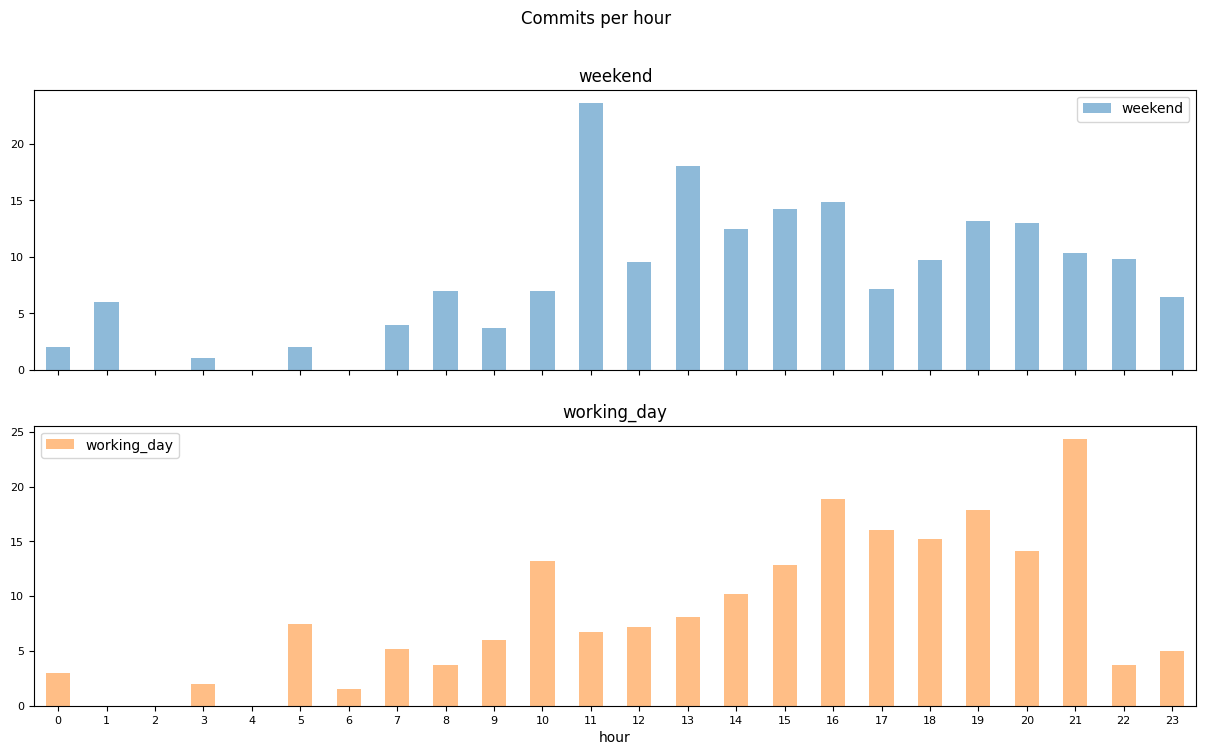

In [29]:
average_commit_counts_per_hour.plot.bar(subplots=True, 
                                        sharex=True,
                                        figsize=(15, 8),
                                        fontsize=8,
                                        title='Commits per hour',
                                        alpha=0.5,
                                        rot=0)

### The dynamics are different on weekdays and weekends. But both graphs show that the number of commits is less at night and in the morning compared to the day and evening.
### The hour when the number of commits is the largest during working days: 21h.
### The hour when the number of commits is the largest during the weekend:  11h.

In [30]:
db_connection.close()